1. Initial Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

In [2]:
# Load the dataset
df = pd.read_csv('../data/question4-stock-data.csv')

In [3]:
# Clean the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.dropna()  # Handle missing values

# Examine the data
print(df.head())
print(df.info())
print(df.describe())

            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-17           0   2.296798  3.291227  3.344743  3.291227  0.000000   
1980-03-18           1   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-19           2   2.306134  3.304606  3.304606  3.304606  3.304606   
1980-03-20           3   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-21           4   2.362154  3.384880  3.438396  3.384880  0.000000   

             Volume  
Date                 
1980-03-17  41109.0  
1980-03-18   9343.0  
1980-03-19      0.0  
1980-03-20  10277.0  
1980-03-21   8409.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10630 entries, 1980-03-17 to 2024-12-27
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10630 non-null  int64  
 1   Adj Close   10630 non-null  float64
 2   Close       

2. Exploratory Data Analysis

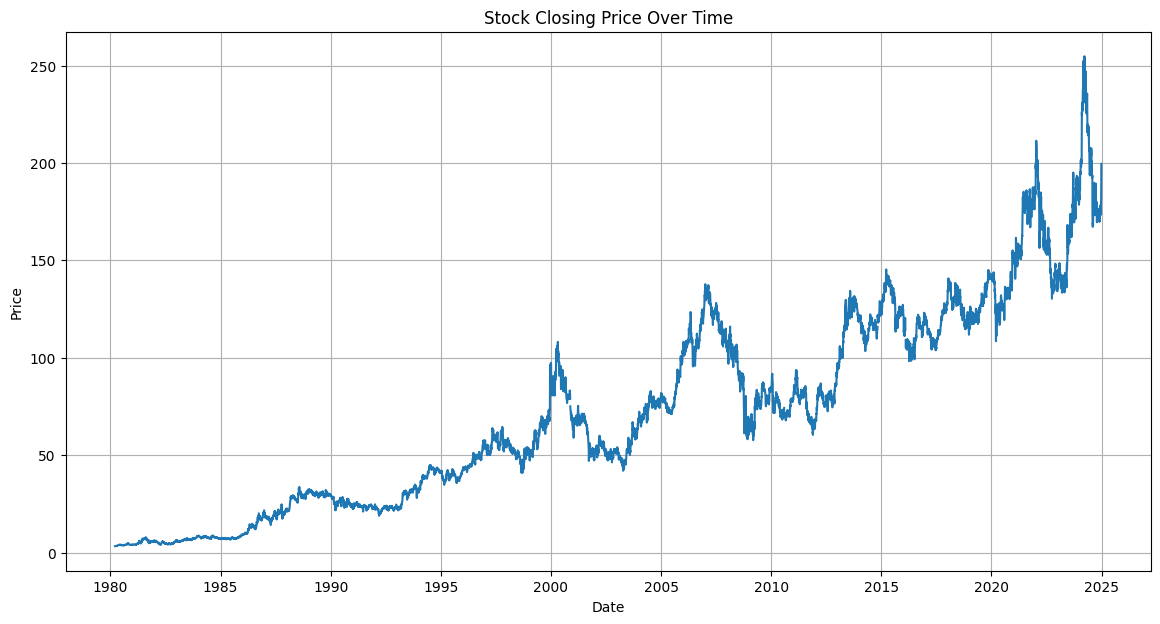

In [4]:
# Visualize stock price trends
plt.figure(figsize=(14, 7))
plt.plot(df['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

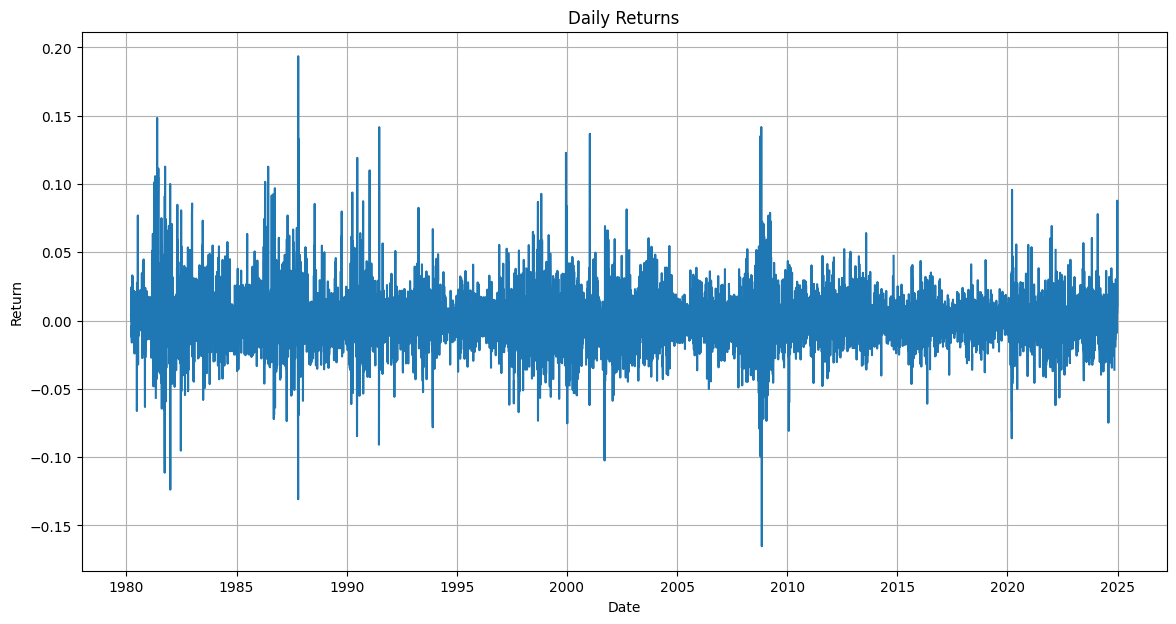

In [5]:
# Analyze daily returns
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(14, 7))
plt.plot(df['Daily_Return'])
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

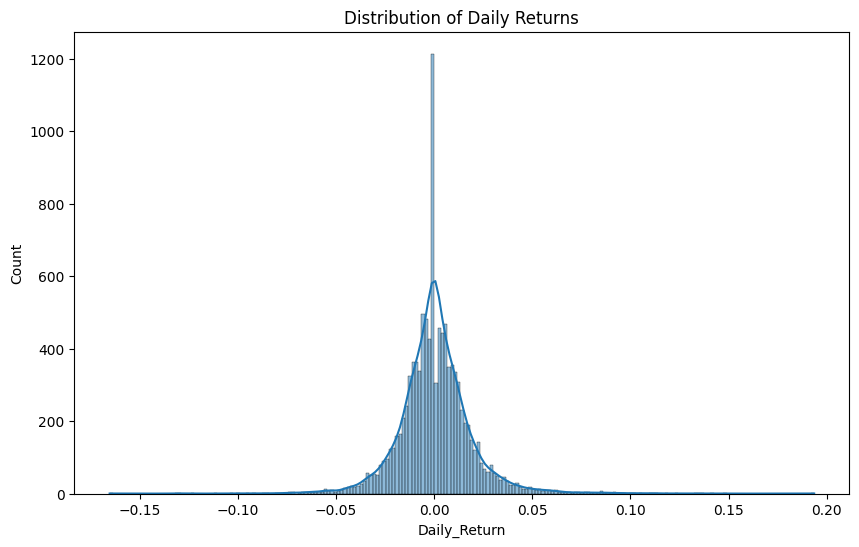

In [6]:
# Distribution of returns
plt.figure(figsize=(10, 6))
sns.histplot(df['Daily_Return'].dropna(), kde=True)
plt.title('Distribution of Daily Returns')
plt.show()

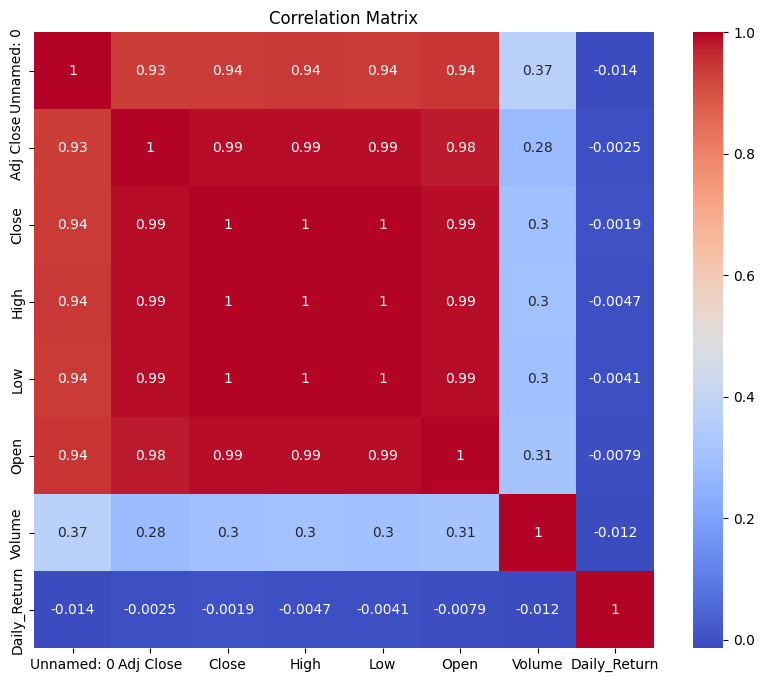

In [7]:
# Correlation matrix of features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

C:\Users\chamo\AppData\Local\Temp\ipykernel_26136\4155946989.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M')['Close'].mean()


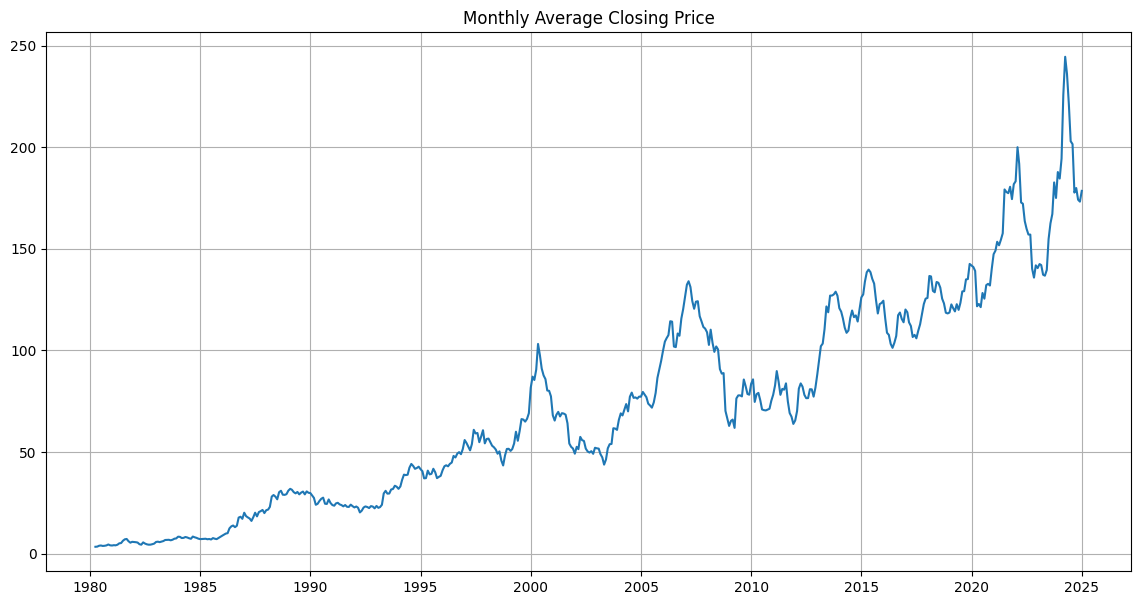

In [8]:
# Check for seasonality
# Monthly analysis
monthly_avg = df.resample('M')['Close'].mean()
plt.figure(figsize=(14, 7))
plt.plot(monthly_avg)
plt.title('Monthly Average Closing Price')
plt.grid(True)
plt.show()

3. Feature Engineering

In [9]:
# Create technical indicators
# Moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

In [10]:
# Relative Strength Index (RSI)
def calculate_rsi(data, period=14):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=period-1, adjust=False).mean()
    ema_down = down.ewm(com=period-1, adjust=False).mean()
    rs = ema_up / ema_down
    return 100 - (100 / (1 + rs))

In [11]:
# Calculate and add RSI to the DataFrame
df['RSI'] = calculate_rsi(df['Close']) # Call calculate_rsi and assign the result to a new column 'RSI'

In [12]:
# MACD
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [13]:
# Bollinger Bands
df['20MA'] = df['Close'].rolling(window=20).mean()
df['20SD'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['20MA'] + (df['20SD'] * 2)
df['Lower_Band'] = df['20MA'] - (df['20SD'] * 2)

In [14]:
# Volatility
df['Volatility'] = df['Close'].rolling(window=20).std()

In [15]:
# Time-based features
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year

In [16]:
# Target variable (5-day future price)
df['Future_Close_5'] = df['Close'].shift(-5)

4. Model Devlopment

In [17]:
# Prepare data for modeling
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'MA5', 'MA20', 'MA50', 'RSI', 'MACD', 'MACD_Signal', 'Volatility', 'DayOfWeek', 'Month']

x = df.dropna()[features]
y = df.dropna()['Future_Close_5']

In [18]:
# Split data
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [19]:
# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(y_train, order=(5,1,0))
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=len(y_test))

C:\Users\chamo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chamo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chamo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

C:\Users\chamo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\chamo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [20]:
# Linear Regression
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
lr_pred = model_lr.predict(x_test)

In [21]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(x_train, y_train)
rf_pred = model_rf.predict(x_test)

In [22]:
# XGBoost
from xgboost import XGBRegressor
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(x_train, y_train)
xgb_pred = model_xgb.predict(x_test)

5. Model Evaluation

In [23]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Direction accuracy
    # Ensure both arrays have the same length for comparison
    min_len = min(len(y_true), len(y_pred))

    # Adjust slicing to ensure both arrays have the same length
    actual_direction = np.sign(y_true.values[1:min_len] - y_true.values[:min_len-1])
    pred_direction = np.sign(y_pred[1:min_len] - y_pred[:min_len-1])

    # Align the lengths of actual_direction and pred_direction
    # by removing the last element of the longer array.

    # Determine the length difference
    len_diff = len(actual_direction) - len(pred_direction)

    # If actual_direction is longer, trim it
    if len_diff > 0:
        actual_direction = actual_direction[:-len_diff]
    # If pred_direction is longer, trim it
    elif len_diff < 0:
        pred_direction = pred_direction[:len_diff]

    direction_accuracy = np.mean(actual_direction == pred_direction)

    print(f"{model_name} RMSE: {rmse:.4f}")
    print(f"{model_name} MAE: {mae:.4f}")
    print(f"{model_name} Direction Accuracy: {direction_accuracy:.4f}")

    return rmse, mae, direction_accuracy

In [24]:
# Evaluate each model
arima_metrics = evaluate_model(y_test, arima_forecast, "ARIMA")
lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")

ARIMA RMSE: 46.3727
ARIMA MAE: 35.0760
ARIMA Direction Accuracy: 0.0029
Linear Regression RMSE: 5.2177
Linear Regression MAE: 3.6267
Linear Regression Direction Accuracy: 0.4785
Random Forest RMSE: 29.4879
Random Forest MAE: 17.6203
Random Forest Direction Accuracy: 0.4938
XGBoost RMSE: 30.3116
XGBoost MAE: 18.3001
XGBoost Direction Accuracy: 0.4933


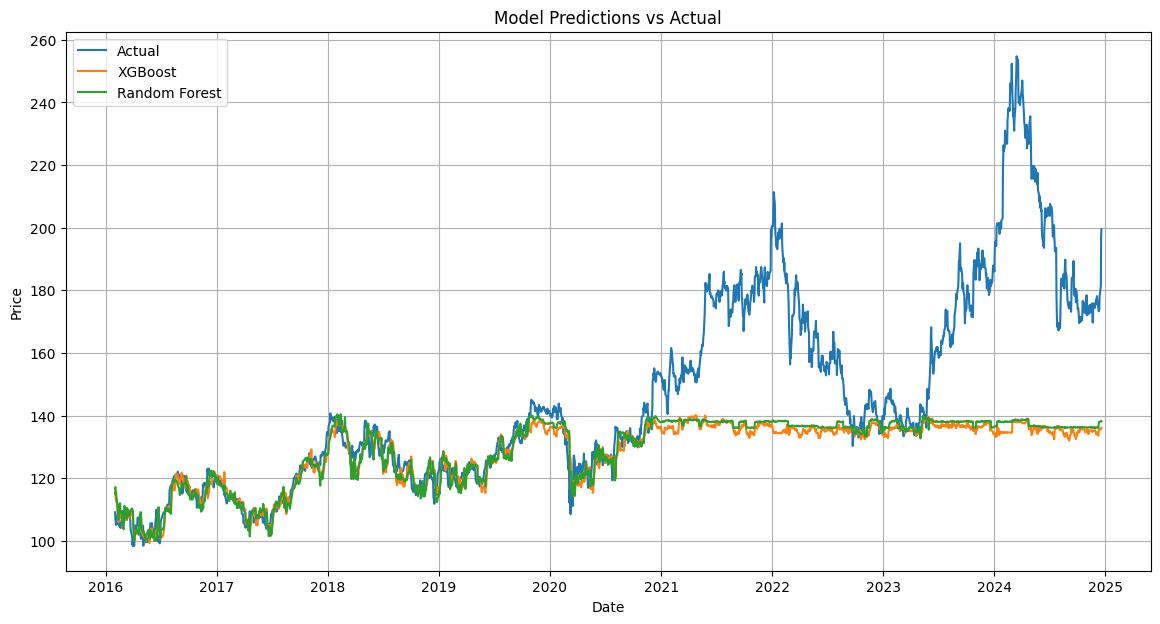

In [25]:
# Visualize predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_pred, label='XGBoost')
plt.plot(y_test.index, rf_pred, label='Random Forest')
plt.title('Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

6. Trading Simulation

In [26]:
# Simulate a simple trading strategy
def simulate_trading(actual, predicted, initial_capital=10000):
    capital = initial_capital
    position = 0
    trades = []

    for i in range(1, len(actual)):
        # Buy signal: if prediction says price will go up
        if predicted[i] > actual[i-1] and position == 0:
            position = capital / actual[i-1]
            capital = 0
            trades.append(('BUY', actual[i-1], position))

        # Sell signal: if prediction says price will go down
        elif predicted[i] < actual[i-1] and position > 0:
            capital = position * actual[i-1]
            position = 0
            trades.append(('SELL', actual[i-1], capital))

    # Final portfolio value
    final_value = capital + (position * actual[-1])
    return final_value, trades

In [27]:
# Run trading simulation for each model
xgb_final_value, xgb_trades = simulate_trading(y_test.values, xgb_pred)
rf_final_value, rf_trades = simulate_trading(y_test.values, rf_pred)

print(f"XGBoost Trading Final Value: ${xgb_final_value:.2f}")
print(f"Random Forest Trading Final Value: ${rf_final_value:.2f}")

XGBoost Trading Final Value: $20444.62
Random Forest Trading Final Value: $14051.83


7. Feature Importance Analysis

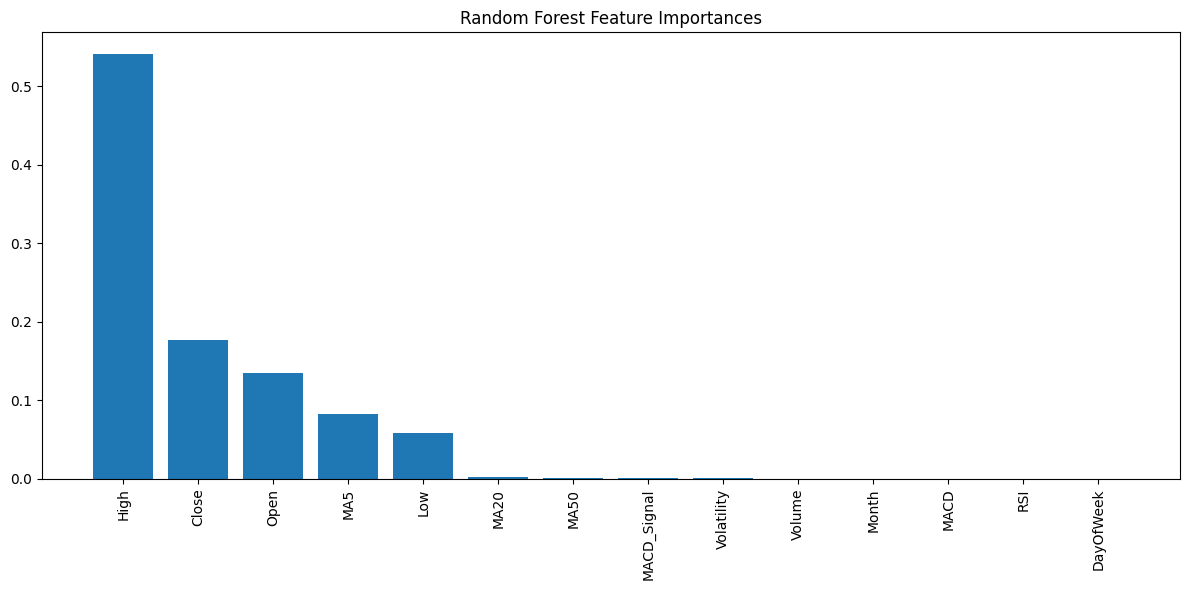

In [28]:
# Analyze feature importance (for Random Forest and XGBoost)
plt.figure(figsize=(12, 6))
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

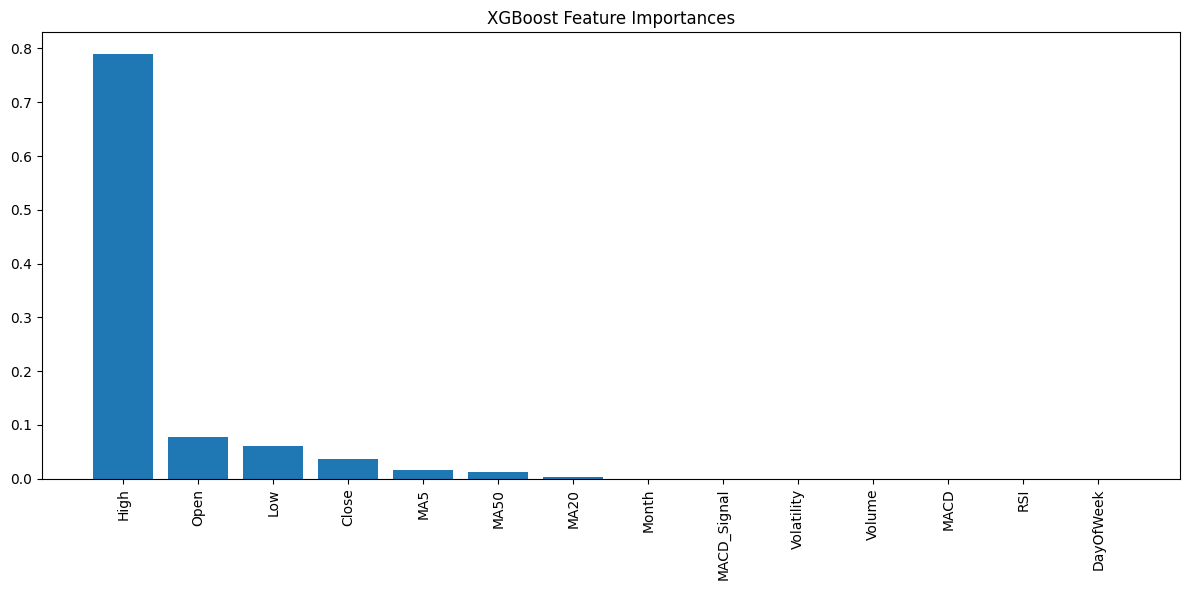

In [29]:
plt.figure(figsize=(12, 6))
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

8. Generate Predictions for Test Period

In [30]:
# Generate predictions for the test period
test_predictions = model_xgb.predict(x_test)

In [31]:
# Create a DataFrame with date and predictions
predictions_df = pd.DataFrame({
    'Date': x_test.index,
    'Predicted_Close': test_predictions
})

In [32]:
# Save to CSV
predictions_df.to_csv('../output/stock_predictions.csv', index=False)